# Building alternative pipeline

* Prepare Hough transform based only on wire information (= energy, time, radial distance)
* Build predictions based on Hough, local information, and local information of left/right neighbors


In [2]:
%run visualizations.ipynb
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [3]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

In [4]:
import pandas
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

### Collect (Raw) Wire Features 

In [5]:
right_neighs = numpy.array([hits.cydet.shift_wire(wire, 1) for wire in range(hits.cydet.n_points)])
left_neighs = numpy.array([hits.cydet.shift_wire(wire, -1) for wire in range(hits.cydet.n_points)])

In [6]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
rel_time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_rhos for i in range(hits.n_events))

In [7]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Convenience Functions for Data

In [8]:
def flatten_data(data, keys, samples, n_features):
    data_flat = data[samples].reshape(-1, n_feats)
    return pandas.DataFrame(data=data_flat, columns=keys)

def mask(data, pol=None):
    if pol==None:
        return data[data['labels'] != 0]
    if pol==0:
        return data[(data['labels'] != 0) & (data['Polarity'] == 0)]
    if pol==1:
        return data[(data['labels'] != 0) & (data['Polarity'] != 0)]

def predict_classifier(classifier, data_samp):
    """
    Return predictions where no hit has zero response by definition.  Return both
    flat predictions, and event sorted predicitions
    """
    # Get the predictions
    pred_evt = classifier.predict_proba(data_samp)[:,1]

    # Check which wires have hits, which ones do not
    not_hit = (data_samp['labels'] == 0).values
    has_hit = (data_samp['labels'] != 0).values

    # Define hit-less wires as definitely not being signal
    pred_evt[not_hit] = 0

    # Slim down the result to a copy with only hits
    pred = pred_evt[has_hit]
    # Reshape the result to be the event shape, for the hoguh transform
    pred_evt = pred_evt.reshape(-1, hits.cydet.n_points)
    
    return pred, pred_evt

In [9]:
## Look up table to map from events to hits
event_to_hit_look = np.arange(hits.n_events*hits.cydet.n_points).reshape(hits.n_events, -1)

## Train/test splitting 

In [10]:
from sklearn.cross_validation import train_test_split
rest, sample_3 = train_test_split(range(len(labels)), train_size=0.6, test_size=0.3)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5)

## Features for Wire GBDT

In [11]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['rel_time'] = rel_time
features['layer_id'] = layer_id

# LR-Neighbour Features
features['r_deposit'] = (deposits * 100)[:, right_neighs]
features['r_rel_time'] = rel_time[:, right_neighs]
features['l_deposit'] = (deposits * 100)[:, left_neighs]
features['l_rel_time'] = rel_time[:, left_neighs]

# Truth values
features['labels'] = labels
features['is_signal'] =  numpy.take([0, 1, 0], labels)

In [12]:
# Define Data
train_features = features.keys()[:-2]
data = numpy.dstack(features.values())
n_feats = data.shape[-1]
print data.shape

(3445, 4482, 9)


In [13]:
data_1, data_2, data_3 = [flatten_data(data, features.keys(), samp, n_feats) 
                          for samp in [sample_1, sample_2, sample_3]]

## NeighbourLevel GBDT

In [14]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [15]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
# Add the GBDT
factory.add_classifier('Local and Neighbour Features', neigh_gbdt)

In [16]:
# Train the classifier
factory.fit(mask(data_1), mask(data_1)['is_signal'])
pass

model Local and Neighbour Features was trained in 116.34 seconds
Totally spent 116.34 seconds on training


In [17]:
# Print these predictions
pred_2, pred_evt_2 = predict_classifier(neigh_gbdt, data_2)

## Testing hough  

In [18]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = (mask(data_2)['labels'] != 0) * abs(mask(data_2)['is_signal'] - pred_2) ** 2

### Quality of classification, reweighted to highlight mislabelled hits
Second scoring is used later to measure quality of Hough transform

In [19]:
print roc_auc_score(mask(data_2)['is_signal'], pred_2)
print roc_auc_score(mask(data_2)['is_signal'], pred_2, sample_weight=problem_weights_2)

0.996783821801
0.283363617546


### Define correspondence matrix separately for even/odd, use several radii

In [20]:
from tracking import HoughSpace

default = [[31.5, 34, 34.5, 2]]
submatrices = []

# Define even and odd layer wires
even_wires = hits.cydet.point_pol != 1
odd_wires = hits.cydet.point_pol == 1

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(hits, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax, sig_rho_sgma=rsgma)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [21]:
# Check the shape, and the number of non-zero entries
new_correspondence.shape, new_correspondence.nnz

((4482, 5634), 264565)

## Rotation of Even Layers from Hough Output

In [22]:
def initialize_integration(this_hough):
    # Initialize the realignment algorithm
    n_phis = this_hough.track.n_by_layer[0]
    n_centres = this_hough.track.n_points
    dphi = 2*np.pi/n_phis
    track_angles = this_hough.track.get_points_rhos_and_phis()[1]
    all_slices = get_slices(dphi, track_angles, n_phis, n_centres)
    return all_slices, dphi

def get_slices(dphi, track_angles, n_phis, n_centres):
    # Integrate over slices in phi
    prev_slice = np.zeros(0)
    all_slices = sparse.lil_matrix((n_phis,n_centres))
    for phi_slice in range(n_phis):
        # Define phi ranges
        phi_0 = phi_slice*dphi
        phi_1 = phi_0 + dphi
        # Get the slice you want
        this_slice = np.where((track_angles >= phi_0) & (track_angles < phi_1))[0]
        # Avoid double counting a point
        this_slice = np.setdiff1d(this_slice, prev_slice)
        prev_slice = this_slice
        # Add these points to the slice
        all_slices[phi_slice, this_slice] = 1.
    # Normalize by the number in each slice to get contribution density in phi
    return sparse.csr_matrix(all_slices / all_slices.sum(axis=1))

def find_ideal_phi(even_inter, odd_inter, upper_lim=6, lower_lim=-6):
    # Find the ideal shift in phi to align images in hough space
    diff = 1000000
    ideal_phi = -100
    for phi_shift in range(lower_lim,upper_lim+1):
        new_int_even = np.roll(even_inter, phi_shift)
        this_diff = np.sum(np.square(new_int_even - odd_inter))
        if this_diff < diff:
            diff = this_diff 
            ideal_phi = phi_shift
    return ideal_phi

def shift_wire_ids(cydet, wire_shift):
    return np.array([cydet.shift_wire(wire, shift)\
                        for wire, shift in zip(np.arange(cydet.n_points), wire_shift)]) 

def get_shifters(cydet, upper_lim=5, lower_lim=-5, dphi=2*np.pi/81.):
    phi_range = np.arange(lower_lim, upper_lim+1)*dphi
    both_shifts = np.dstack(np.vstack(get_even_shift(cydet, phi_shift)) for phi_shift in phi_range)
    forward_shift = both_shifts[0]
    backwards_shift = both_shifts[1]
    return forward_shift.T, backwards_shift.T

def get_even_shift(cydet, phi_shift=2*np.pi/81.):
    n_wires = cydet.n_points
    shift_by_layer = np.zeros(len(cydet.dphi_by_layer))
    shift_by_layer[::2] = -np.round(phi_shift/cydet.dphi_by_layer).astype(int)[::2]
    shift_by_wire = np.take(shift_by_layer, cydet.point_layers)
    forward_index = shift_wire_ids(cydet, shift_by_wire)
    backward_index = np.argsort(forward_index)
    return forward_index, backward_index

def shift_result(results, shifters, ideal_rotate):
    return np.vstack(evt_res[shifters[evt_rot]] for evt_res, evt_rot in zip(results, ideal_rotate))

def perform_hough_shift(to_align, hough, upper_lim=2, lower_lim=-6):
    # Initialize the integration
    all_slices, dphi = initialize_integration(hough)
    even_forw, even_back = get_shifters(hough.hit_data.cydet, upper_lim=upper_lim, lower_lim=lower_lim, dphi=dphi)
    
    # Get even and odd contributions
    hough_image_even = to_align[:,:hough.track.n_points]
    hough_image_odd = to_align[:,hough.track.n_points:]

    integral_even = all_slices.dot(hough_image_even.T).T
    integral_odd = all_slices.dot(hough_image_odd.T).T
    
    # Find the ideal rotations
    ideal_rotate = np.array([find_ideal_phi(integral_even[evt,:],\
                                          integral_odd[evt,:],
                                         upper_lim=upper_lim, lower_lim=lower_lim)\
                           for evt in range(to_align.shape[0])])
    ideal_rotate -= lower_lim
    return ideal_rotate, even_forw, even_back, integral_even, integral_odd

def plot_hough_shift(int_even, int_odd, this_phi):
    plt.bar(range(len(int_even)), int_even, alpha=0.5)
    plt.bar(np.arange(len(int_odd)), int_odd, color="red",alpha=0.5)
    show()
    plt.bar(range(len(int_even)), int_even, alpha=0.5)
    plt.bar(np.roll(np.arange(len(int_odd)), this_phi), int_odd, color="red",alpha=0.5)
    show()

## Traning second classifier

### Hough Image Without Shift

In [75]:
from tracking import HoughTransformer
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, hough.norm_track_neighs, pred_evt_2, alpha_max=2., alpha_rw=2.)

In [76]:
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

# Get the hough results
hough_result_2, hough_image_2 = hough_transformer.transform(pred_evt_2)
hough_result_3, hough_image_3 = hough_transformer.transform(pred_evt_3)

### Hough Image With Shift

In [77]:
# Do the first transform to get the hough space that needs to be aligned
aligner = HoughTransformer(new_correspondence, hough.norm_track_neighs, pred_evt_2, alpha_rw=2., alpha_max=2.)
_ , to_align_2 = aligner.transform(pred_evt_2)
_ , to_align_3 = aligner.transform(pred_evt_3)

# Shift this hough space to get the even and odd layers agreeing
ideal_rotate_3, even_shifts_3, even_orig_3, integral_even_3, integral_odd_3 =\
        perform_hough_shift(to_align_3, hough, upper_lim=2, lower_lim=-6)
ideal_rotate_2, even_shifts_2, even_orig_2, integral_even_2, integral_odd_2 =\
        perform_hough_shift(to_align_2, hough, upper_lim=2, lower_lim=-6)

# Shift the results to match up the even and odd layers
shift_pred_evt_3 = shift_result(pred_evt_3, even_shifts_3, ideal_rotate_3)
shift_pred_evt_2 = shift_result(pred_evt_2, even_shifts_2, ideal_rotate_2)

# Hough Transform on the shifted results
shifted_hough_result_3, shifted_hough_image_3 = hough_transformer.transform(shift_pred_evt_3)
shifted_hough_result_2, shifted_hough_image_2 = hough_transformer.transform(shift_pred_evt_2)

# Unshift the results to add them as a feature
unshifted_hough_result_3 = shift_result(shifted_hough_result_3, even_orig_3, ideal_rotate_3)
unshifted_hough_result_2 = shift_result(shifted_hough_result_2, even_orig_2, ideal_rotate_2)

In [78]:
# Add these as features
data_2['Hough'] = hough_result_2.flatten()
data_2['Shift_Hough'] = unshifted_hough_result_2.flatten()

data_3['Hough'] = hough_result_3.flatten()
data_3['Shift_Hough'] = unshifted_hough_result_3.flatten()

In [79]:
# Add this to the feature list
train_features_full = train_features + ['Hough']
train_features_shift = train_features + ['Shift_Hough']

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_full) 

s_hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_shift) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=['deposit'])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Shift Hough, Local and Neighbour Features', s_hough_gbdt)
factory.add_classifier('Hough, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [81]:
# Train the classifier
factory.fit(mask(data_2), mask(data_2)['is_signal'])
pass

model Local and Neighbour Features was trained in 240.16 seconds
model Shift Hough, Local and Neighbour Features was trained in 124.76 seconds
model Hough, Local and Neighbour Features was trained in 124.66 seconds
model Energy Deposition was trained in 61.95 seconds
Totally spent 551.53 seconds on training


In [98]:
# Test it on the last set of data
pred_final_diag_3 = factory.test_on(mask(data_3), mask(data_3)['is_signal'])
pred_final_3, pred_final_evt_3 = predict_classifier(hough_gbdt, data_3)
pred_final_shift_3, pred_final_shift_evt_3 = predict_classifier(s_hough_gbdt, data_3)
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

In [99]:
# TODO clean this up
figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            ('l_rel_time' , "Left Timing"),  
            ('r_rel_time' , "Right Timing"),
            ("layer_id" , "R Distance"), 
            ('r_deposit' , 'Right Energy'), 
            ('l_deposit' , 'Left Energy'), 
            ('rel_time' , "Timing"),
            ('deposit' , 'Energy'), 
            ('Hough' , r"Hough, $W_j''$"),
        ])
def plot_feature_importance(rep_classifier, feat_label_dict):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=False)
    ax = plt.subplot(111)
    ax.bar( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_xticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_ylabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='y' ,color='grey', linestyle='--')
    ax.grid(b=True, which='minor', axis='y' , color='grey', linestyle=':')
    ax.set_xticklabels(feat_label_dict.values()[::-1],  rotation='vertical')
    ax.set_yticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_yticks()])
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict):
    corr = pred_final_diag_3.features_correlation_matrix(features=train_features+["Hough"],
                                tick_labels=[feat_label_dict[key] for key in train_features_full])
    corr.fontsize = 15
    corr.cmap = "RdBu"
    return corr.plot()

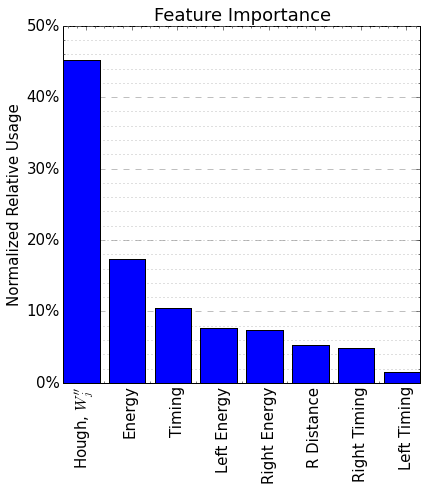

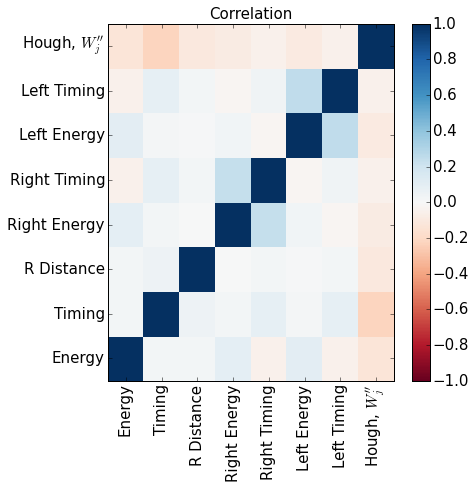

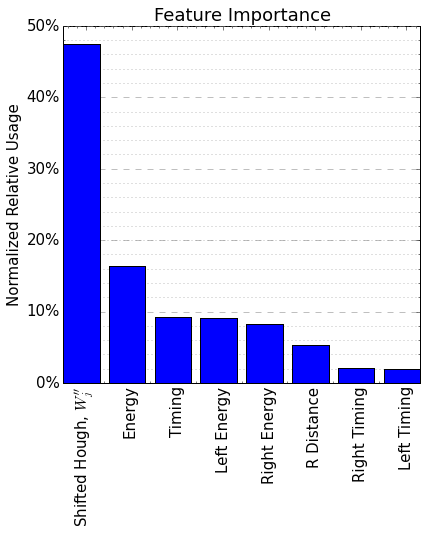

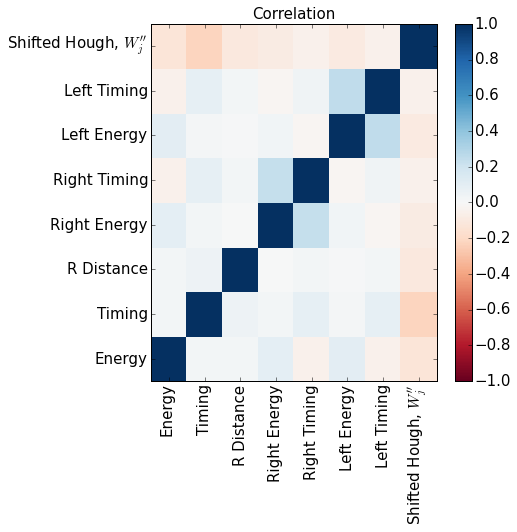

In [101]:
hough_level = factory["Hough, Local and Neighbour Features"]
plot_feature_importance(hough_level, feat_label_dict)
show()
plot_feature_correlations(factory, feat_label_dict)
show()

feat_label_dict['Hough'] = r"Shifted Hough, $W_j''$"
s_hough_level = factory["Shift Hough, Local and Neighbour Features"]
plot_feature_importance(s_hough_level, feat_label_dict)
show()
plot_feature_correlations(factory, feat_label_dict)
show()

(<matplotlib.axes._subplots.AxesSubplot at 0x43721f90>,
 <matplotlib.figure.Figure at 0x43721ad0>)

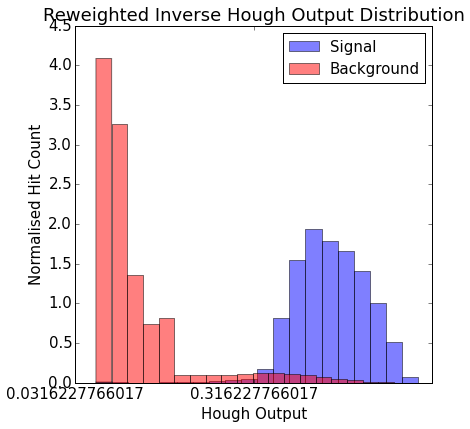

In [102]:
plot_feature( (data_3['Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x2ad8d890>,
 <matplotlib.figure.Figure at 0x21f80590>)

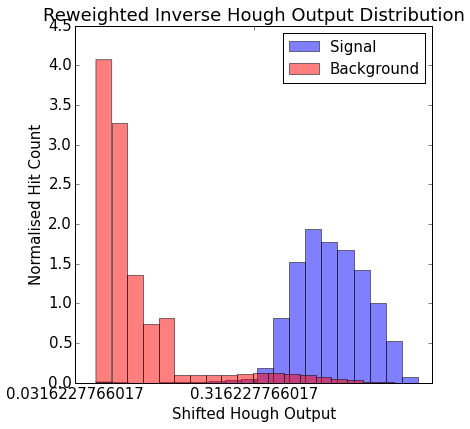

In [103]:
plot_feature( (data_3['Shift_Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Shifted Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)


## Final quality of signal vs bck wires

0.999289210993
0.999280241421


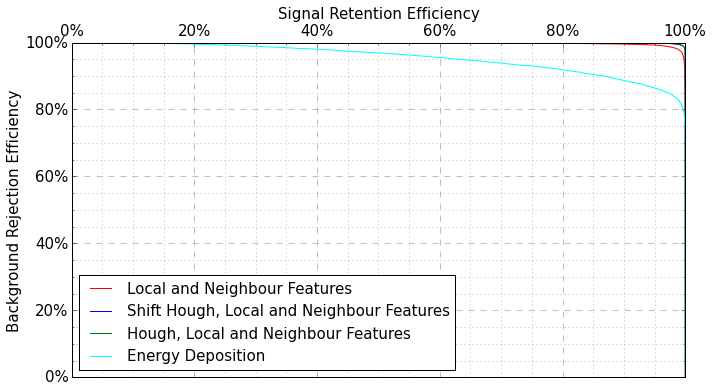

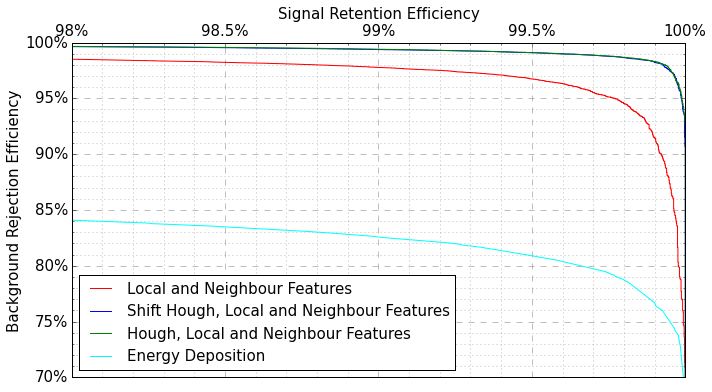

In [104]:
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_final_shift_3)

figsize(11,6) 
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=False)
plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc.png", bbox_inches="tight")
show()
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=True)
plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc_zoom.png", bbox_inches="tight")
show()

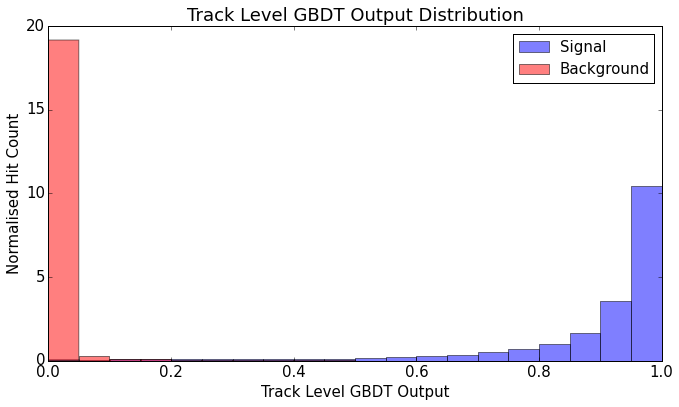

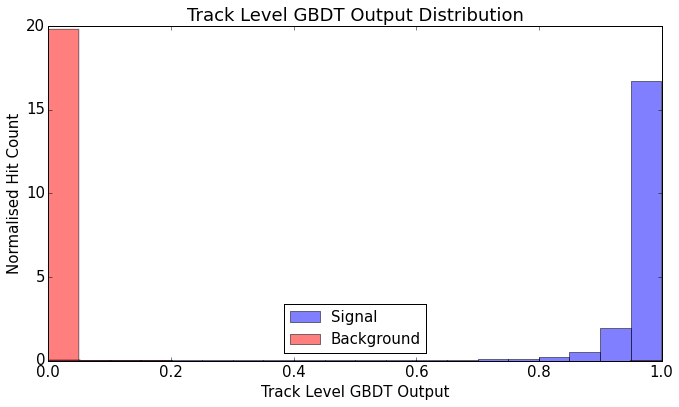

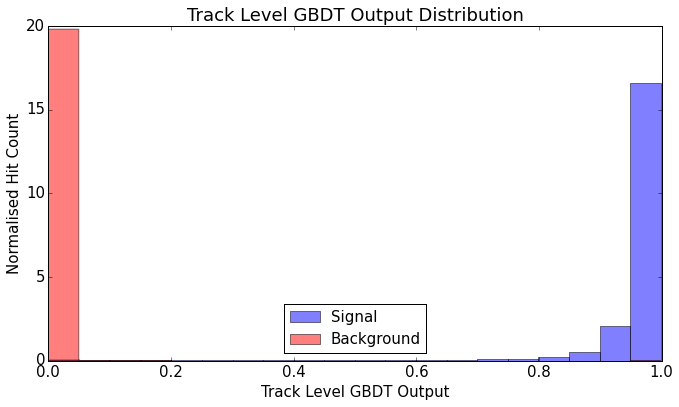

In [105]:
plot_feature( pred_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count", 
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_shift_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

In [106]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_3, sample_weight=problem_weights_3)

0.997882994965
0.219145329825


In [108]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_final_shift_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_final_shift_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_final_shift_3, sample_weight=problem_weights_3)

0.999280241421
0.132851721213


##RANSAC Implimentation

In [109]:
from sklearn import linear_model
#print linear_model.LinearRegression__doc__
#print linear_model.RANSACRegressor.__doc__

In [110]:
# Get the actual circle parameters for the fit from the linearized parameters
def get_circle(x_coeff, y_coeff, intercept):
    return x_coeff/2, y_coeff/2, np.sqrt(4*intercept + x_coeff**2 + y_coeff**2)/2

In [111]:
# Check that the fit returns a circle that passes through the production target
def inside_target(model, X, y):
    a, b, r = get_circle(model.coef_[0][0], model.coef_[0][1], model.intercept_)
    return abs(np.sqrt(a**2 + b**2) - r) < 10

In [112]:
# GBDT likes these data points 
#def good_points(X, y):
#    a, b, r = get_circle(model.coef_[0][0], model.coef_[0][1], model.intercept_)
#    return abs(np.sqrt(a**2 + b**2) - r) < 10

In [113]:
# Geometric considerations for the fit
wire_x, wire_y = hits.cydet.get_points_xs_and_ys()
# Linearize the input problem
wire_xy = np.vstack([wire_x, wire_y]).T
wire_z  = np.square(wire_x) + np.square(wire_y)
        
def ransac_fit(labels, preds, min_hits=13, plot=False):
    # Initialze parameters
    x1, y1, r1 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    x2, y2, r2 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    this_score = -1.*np.ones(wire_z.shape[0])
    
    # Get wires to fit
    even_sig = even_wires & preds
    odd_sig = odd_wires & preds
    
    # Plot the input to the fit
    if plot:
        plot_output(to_plot, hits.cydet, size=40*preds)
        plot_add_outlines(to_plot, hits.cydet)

    # Skip if either layer does not have enough hit points
    # if (sum(even_sig) < min_hits) or (sum(odd_sig) < min_hits):
    #     print "Skipped"
    #    if plot:
    #        show()
    #    return

    for pol, signal in enumerate([even_sig, odd_sig]):

        # Get the points to fit
        fit_x, fit_y = wire_x[signal], wire_y[signal]
        fit_xy = np.vstack([fit_x,fit_y]).T
        # Linearize the equation
        fit_z = np.square(fit_x) + np.square(fit_y)

        # Fit line using all data
        model = linear_model.LinearRegression()
        try:
            model.fit(fit_xy, fit_z)
        except ValueError:
            if plot:
                print "Skipped Normal"
                show()
            return x1, y1, r1, x2, y2, r2, this_score
        
        # Robustly fit linear model with RANSAC algorithm
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),
                                                   is_model_valid=inside_target,
                                                   max_trials=1000)
        try:
            model_ransac.fit(fit_xy, fit_z)
        except ValueError:
            if plot:
                print "Skipped RANSAC"
                show()
            return x1, y1, r1, x2, y2, r2, this_score
        
        inlier_mask = signal[model_ransac.inlier_mask_]
        outlier_mask = signal[np.logical_not(model_ransac.inlier_mask_)]

        # Plot the output
        labels = np.zeros(hits.cydet.n_points)
        labels[inlier_mask] = 1
        labels[outlier_mask] = 2

        # Get the regular fit
        x1[pol], y1[pol], r1[pol] = get_circle(model.coef_[0], model.coef_[1] , model.intercept_)

        # Get the RANSAC fit
        x2[pol], y2[pol], r2[pol] = get_circle(model_ransac.estimator_.coef_[0][0], 
                         model_ransac.estimator_.coef_[0][1] , model_ransac.estimator_.intercept_)

        # Make sure we're plotting all points
        assert len(inlier_mask) + len(outlier_mask) == sum(signal),\
            "{} {}".format(len(inlier_mask) + len(outlier_mask), len(signal))    
        if plot:
            plot_add_circle(x1[pol], y1[pol], r1[pol])
            print "Fit:" + str(r1[pol])
            plot_add_circle(x2[pol], y2[pol], r2[pol], color="red")
            print "RANSAC Fit:" + str(r2[pol]) + "\n"

        # Score the wires by distance from RANSAC
        this_score = model_ransac.estimator_.predict(wire_xy)[:,0]
        this_score -= wire_z
        this_score = np.absolute(this_score)
    if plot:
        show()
    return x1, y1, r1, x2, y2, r2, this_score

In [114]:
# Define threshold GBDT output to fit to
fpr, tpr, values =  roc_curve(mask(data_3)['is_signal'], pred_final_3)
threshold = np.where(tpr > 0.99)[0][0]
print "TPR: {}".format(tpr[threshold]),\
      "FPR: {}".format(fpr[threshold]),\
      "VALUE: {}".format(values[threshold])

# Define the wires to be fit and their locations
cut_pred_final_3 = pred_final_evt_3 > values[threshold]
fit_evts = cut_pred_final_3.shape[0]

TPR: 0.990001649474 FPR: 0.00603207712039 VALUE: 0.340736827901


In [115]:
# Score the wires by distance from RANSAC
score = np.zeros(data_3['labels'].shape[0]) 
for evt in range(len(sample_3)):
    if evt%100 == 0:
        print evt
    evt_hits = event_to_hit_look[evt]
    to_fit = data_3["labels"].values[evt_hits]
    output = ransac_fit(to_fit, cut_pred_final_3[evt,:])
    if output != None:
        score[evt_hits] =  output[-1]
data_3['score'] = score

0
100
200
300
400
500
600
700
800
900
1000


In [116]:
good_events = data_3[data_3['score'] != -1].shape[0]/4482
total_events = data_3.shape[0]/4482
print good_events/float(total_events)

0.94003868472


/home/elg112/.local/lib/python2.7/site-packages/pandas/core/frame.py:1815: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


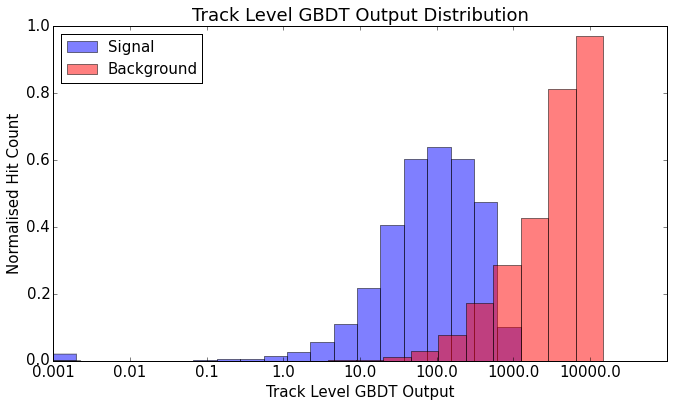

In [117]:
plot_feature((mask(data_3)[data_3['score'] != -1]['score'].values +0.001), 
             mask(data_3)[data_3['score'] != -1]['labels'].values, xlog=True,
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

## Visualization of Progress of Algorithm

In [118]:
#optimize hough to improve track purity, use RANSAC to shed background islands

In [133]:
# Event information\
event = 2
evt_hits = event_to_hit_look[event]
to_plot = data_3["labels"].values[evt_hits]
hough_output = data_3["Hough"].values[evt_hits]
plot_hough_image_3 = hough_image_3[event,:hough.track.n_points] + hough_image_3[event,hough.track.n_points:]

# Shifted plot informatiob
shift_plot = to_plot[even_shifts_3[ideal_rotate_3[event]]]
shift_hough_output = shifted_hough_result_3[event,:]
shift_hough_image = shifted_hough_image_3[event,:hough.track.n_points] +\
                    shifted_hough_image_3[event,hough.track.n_points:]

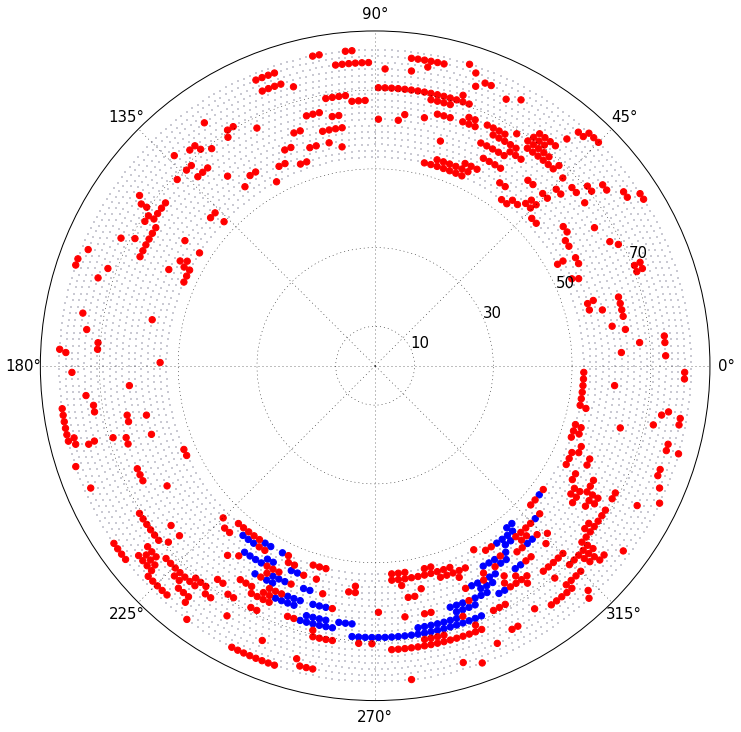

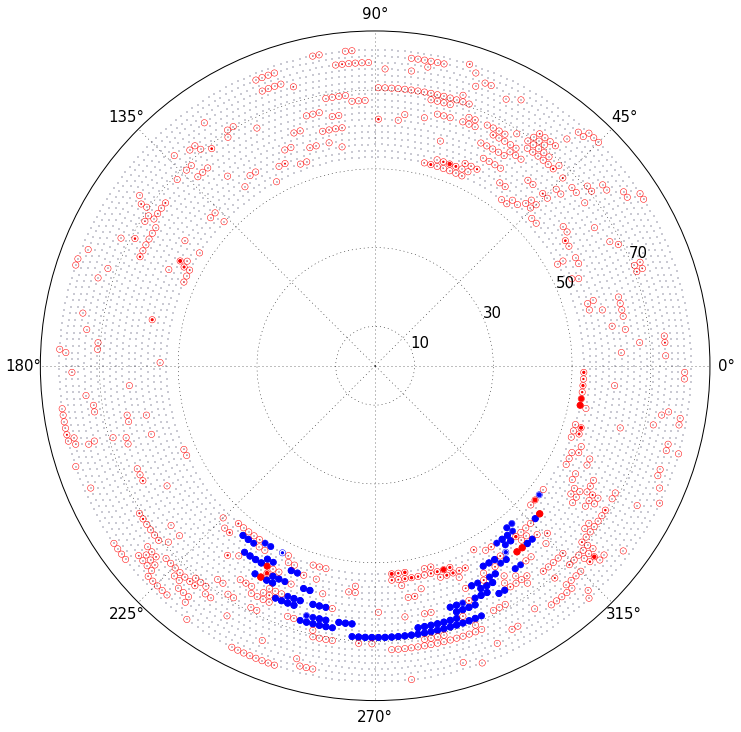

Length of draw tracks are 234


/home/elg112/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


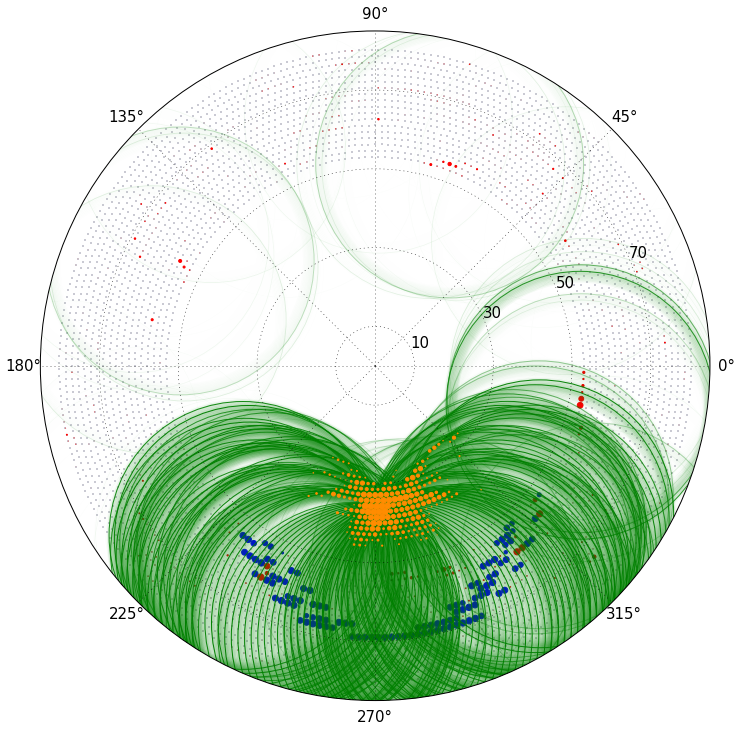

Length of draw tracks are 234


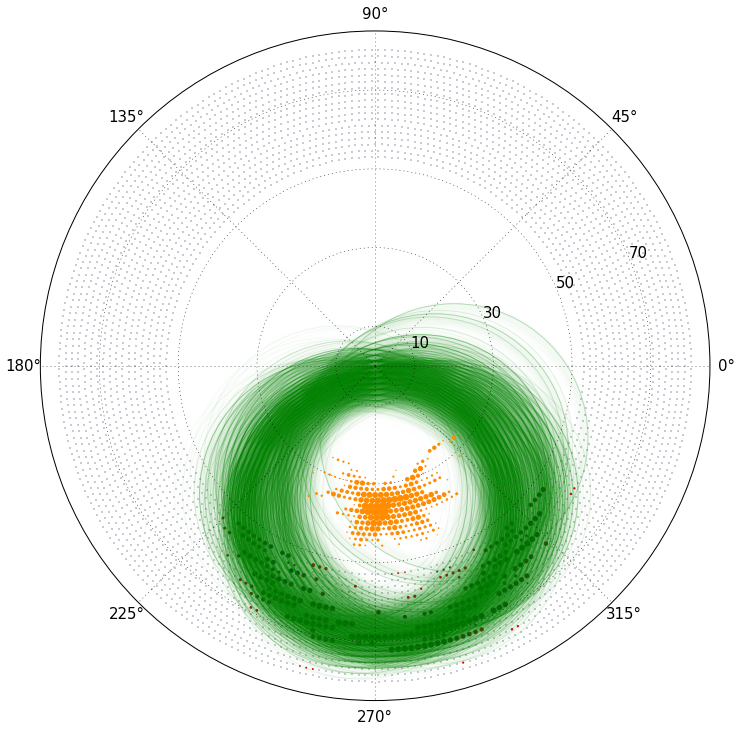

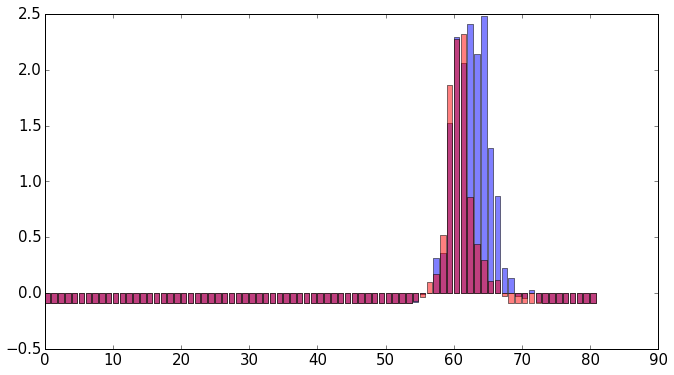

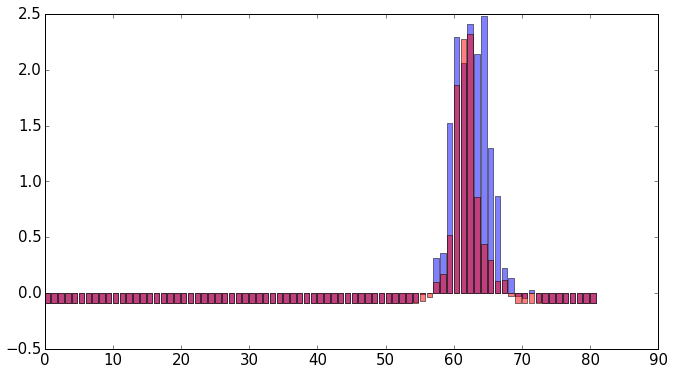

Length of draw tracks are 234


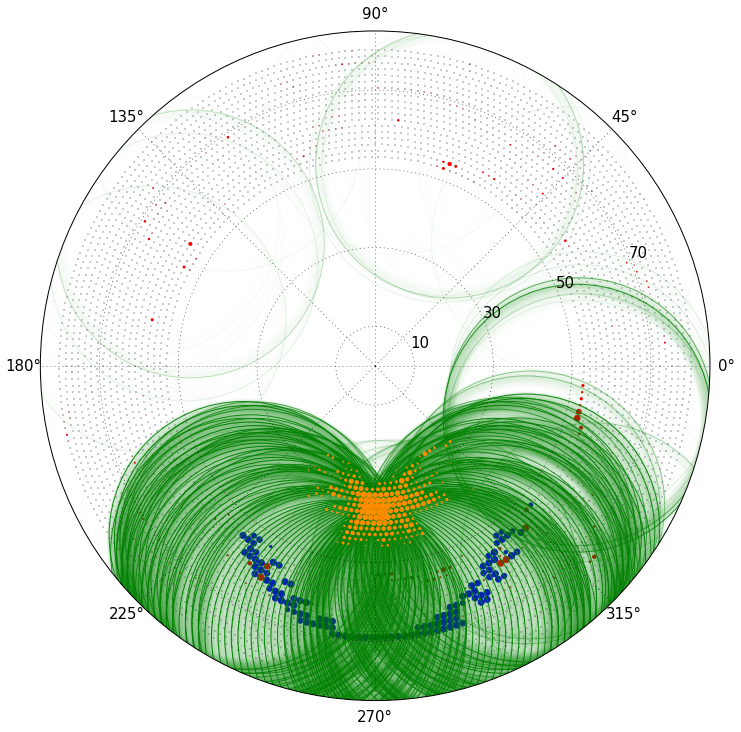

Length of draw tracks are 235


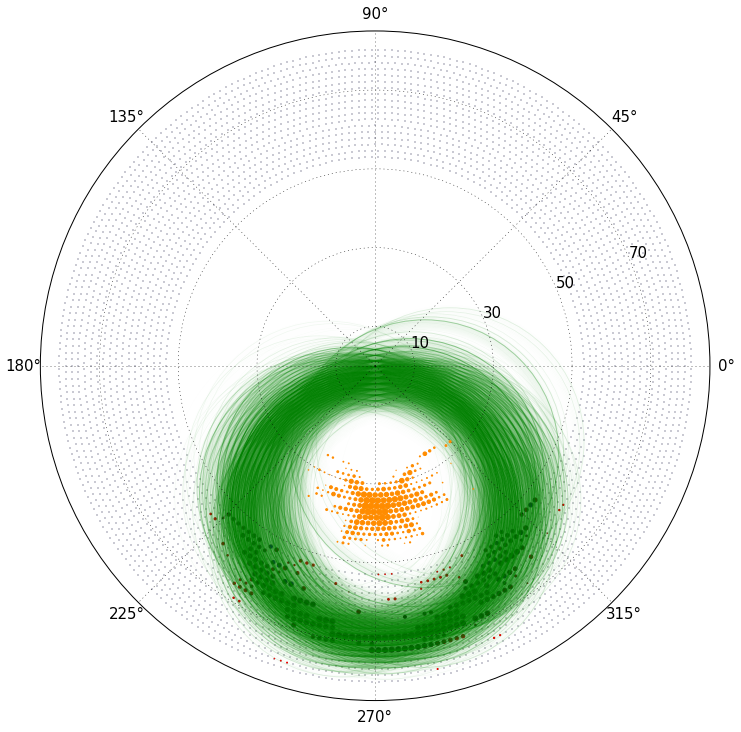

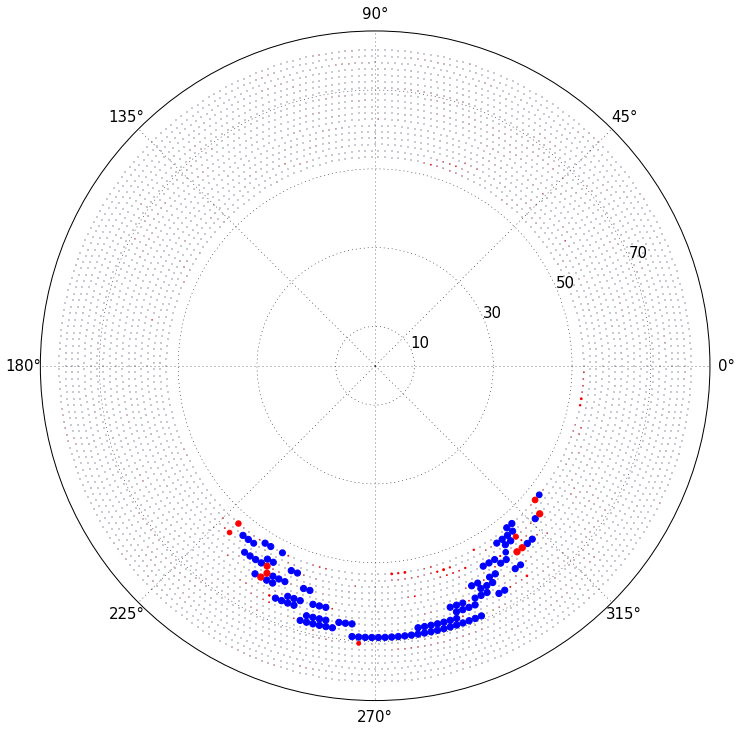

Fit:34.7803975096
RANSAC Fit:34.7803975096

Fit:33.5145588708
RANSAC Fit:33.5145588708



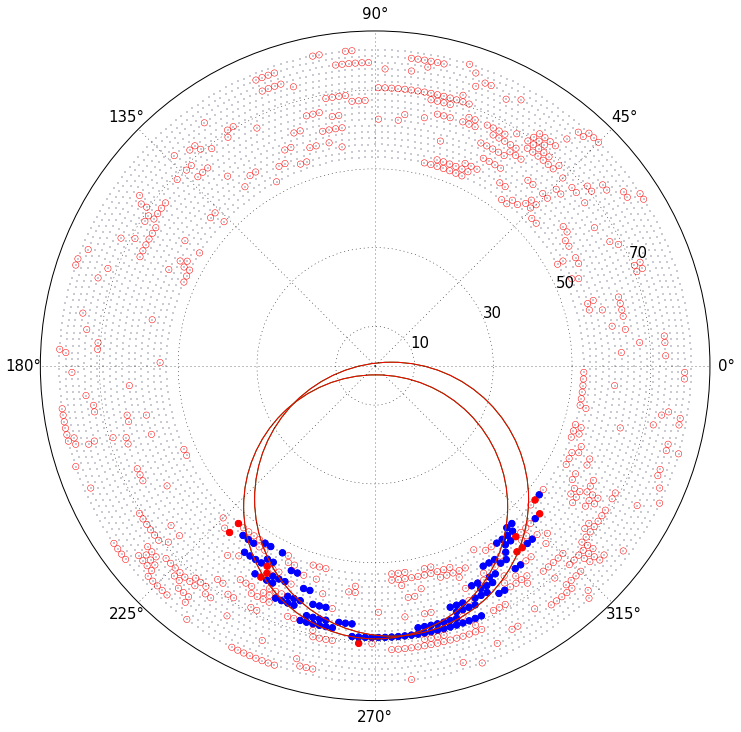

(array([ 4.17862116,  0.12984616]), array([-33.87490787, -35.82773634]), array([ 34.78039751,  33.51455887]), array([ 4.17862116,  0.12984616]), array([-33.87490787, -35.82773634]), array([ 34.78039751,  33.51455887]), array([ 2955.65420258,  3076.15557584,  3196.5494733 , ...,  6272.12450634,
        6392.35968196,  6512.68262726]))


In [136]:
# Basic output
plot_output(to_plot, hits.cydet)
show()
# First GBDT output
plot_output(to_plot, hits.cydet, size=plot_norm_size(pred_evt_3[event,:]))
plot_add_outlines(to_plot, hits.cydet)
show()

# Hough output
plot_output(to_plot, hits.cydet, size=plot_norm_size(pred_evt_3[event,:]), add_transform=True)
plot_add_tracks(hits.cydet, hough, size=plot_norm_size(plot_hough_image_3,40))
show()
# Inverse Hough output
plot_output(to_plot, hits.cydet, size=plot_norm_size(hough_output))
plot_add_tracks(hits.cydet, hough, size=plot_norm_size(plot_hough_image_3,40), add_transform=True,
                tolerance=0.00)
show()    

# Shift in Hough Space
# TODO magic number here
plot_hough_shift(integral_even_3[event,:], integral_odd_3[event,:], ideal_rotate_3[event]-6)
show()

# Hough output
plot_output(shift_plot, hits.cydet, size=plot_norm_size(shift_pred_evt_3[event,:]), add_transform=True)
plot_add_tracks(hits.cydet, hough, size=plot_norm_size(shift_hough_image,40))
show()
# Inverse Hough output
plot_output(shift_plot, hits.cydet, size=plot_norm_size(shift_hough_output))
plot_add_tracks(hits.cydet, hough, size=plot_norm_size(shift_hough_image,40), add_transform=True,
                tolerance=0.00)
show()
# Final
plot_output(to_plot, hits.cydet, size=plot_norm_size(pred_final_evt_3[event,:]))
show()

# RANSAC 
print ransac_fit(to_plot, cut_pred_final_3[event,:], plot=True)